In [1]:
import pandas as pd
import numpy as np

## 1 Data

In [25]:
df = pd.read_csv('all_ECB_speeches.csv', sep = '|')
#pd.set_option('display.max_colwidth',None)
#pd.set_option('display.max_colwidth',-1)
#pd.set_option('display.width', 5)

In [26]:
df.head(1)

,date,speakers,title,subtitle,contents
0,2021-05-27,Isabel Schnabel,Societal responsibility and central bank indep...,"Keynote speech by Isabel Schnabel, Member of t...",SPEECH Societal responsibility and central...


### Subset

In [36]:
# speech in 2021
d21 = df[(df['date'] > '2020-06-01') & (df['date'] < '2020-12-31')]
#drop empty row
d21 = d21.dropna(how ='any')
#dataframe | remain only two colums
d21 = d21[['date','contents']]
d21.head(1)

,date,contents
36,2020-12-16,SPEECH The importance of trust for the ECB...


In [37]:
type(d21.iloc[1,0])

str

#### Merge text groupby day

In [38]:

from datetime import date 
d21['date'] = pd.to_datetime(d21['date']) #convert columns date to datetime

#groupby speech in the same date
d21['date'] = pd.to_datetime(d21['date'])
d21['speeches'] = d21.groupby(['date'])['contents'].transform(lambda x: ','.join(x)) 
df21 = d21[['date','speeches']].drop_duplicates()

#---
df21.head(10) #df21.shape[0]

,date,speeches
36,2020-12-16,SPEECH The importance of trust for the ECB...
39,2020-12-14,SPEECH Welcome address Welcome address b...
41,2020-11-27,SPEECH From the payments revolution to the...
42,2020-11-26,SPEECH Monetary policy in a pandemic: ensu...
44,2020-11-24,SPEECH COVID-19 and monetary policy: Reinf...
45,2020-11-23,SPEECH Shifting tides in euro area money m...
46,2020-11-20,SPEECH Fostering sustainable growth in Eur...
47,2020-11-19,SPEECH COVID-19 and the liquidity crisis o...
49,2020-11-16,SPEECH The euro area financial sector in t...
50,2020-11-12,SPEECH Banking Union and Capital Markets U...


#### Split into sentences

In [39]:
a = df21
cols_name = ['yymm', 'sent']
df_sent = pd.DataFrame(columns=cols_name)
for i in range(a.shape[0]):
    yymm = a.iloc[i][0]
    text = a.iloc[i][1]
    sent_temp = text.split('.')
    df_temp = pd.DataFrame(columns=cols_name)
    for t in sent_temp:
        arr = [yymm,t] #value of a ro
        df_length = len(df_sent) #
        df_sent.loc[df_length] = arr 

In [40]:
df_sent

,yymm,sent
0,2020-12-16,SPEECH The importance of trust for the ECB...
1,2020-12-16,Zur Pathogenese europäischer Gegenwarten” at ...
2,2020-12-16,I am pleased to speak to you today about Euro...
3,2020-12-16,"The seminar series “Havarie Europa”, literall..."
4,2020-12-16,Public trust in the European Union (EU) and E...
...,...,...
7837,2020-06-08,I very much welcome the European Parliament’s...
7838,2020-06-08,I count on this house and this Committee to d...
7839,2020-06-08,"At the same time, you can rest assured that ..."
7840,2020-06-08,I now stand ready to answer your questions


## 2 ECB Communication

We measure the ECB's communication by two features: Topic and Tone. That is, we determine first the economic topic of the speeches. After that, we measures how they are talking about it (tone). In this paper, we make use of Latent Dirichlet Allocation (LDA) to know when they are talking about economic topic and a balance measure based on dictionary methods, or word counting, to measure tone. By combining these two approaches allows us to measure topic-level tone which helps to deal, somewhat, with the weakness of dictionary methods. That is, rather than just measure words associated with expansion, we can measure expansion words associated with GDP growth rather than risk premia.

### Step 1:  Assign topic to a sentence.

In [41]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
#---
import string
import re
import nltk

In [43]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
ps = PorterStemmer()

In [44]:
otherstop =  ['-', '%', 'g','bank', 'ecb','euro', 'also','speech','-;','le','p','r','j','f','c','one',
             'e','op','-','_','left','(chart', 'likely', 'could','l','n','(question', '()','del','di', 'u','w',
                'h', 'b','k', 'q', 'v']
stop= stopwords.words('english')
stop.extend(list(string.punctuation))
stop.extend(otherstop)
lemma=WordNetLemmatizer()
ps = PorterStemmer()
def clean(docx):
    doc = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(docx))
    doc1 = re.sub(r'\d+', '', doc)
    stop_free=" ".join([i for i in doc1.lower().split() if i not in stop])
    normalized=" ".join(lemma.lemmatize(word) for word in stop_free.split())
    #normalized1 =" ".join(ps.stem(word) for word in normalized.split())
    return normalized

In [45]:
text_complete = df_sent['sent'].values.tolist()
doc_clean=[clean(text).split() for text in text_complete]

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)
cv=CountVectorizer(min_df=2,max_df=50,#ngram_range=(1,2),
                   token_pattern=None,
                   tokenizer=lambda doc:doc,preprocessor=lambda doc:doc, 
                   stop_words = frozenset(stop))
#'''INPUT HERE'''
cv_features=cv.fit_transform(doc_clean) 
vocabulary=np.array(cv.get_feature_names())

In [47]:
'''Using sklearn.decomposition LDA with 11 topics'''
from sklearn.decomposition import LatentDirichletAllocation
TOTAL_TOPICS = 15
lda_model=LatentDirichletAllocation(n_components=TOTAL_TOPICS,
                                    max_iter=10,max_doc_update_iter=10,
                                    learning_method='online',batch_size=128,
                                    learning_offset=50.,random_state=42,n_jobs = -1)

'''Using the transformer 'fit_transform'''
document_topics=lda_model.fit_transform(cv_features)

''' Extraqcting the most important 10 terms for each topic'''
topic_terms=lda_model.components_
top_terms=15 # number of 'top terms'
topic_key_terms_idxs=np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]

'''INPUT vocabulary'''
topic_keyterms=vocabulary[topic_key_terms_idxs]
topics=[', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth',None)
topics_df=pd.DataFrame(topics,columns=['Term per Topic'], index=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df



,Term per Topic
Topic1,"reserve, extent, guidance, de, fully, cut, associated, federal, president, energy, prevent, caused, policymakers, largely, forceful"
Topic2,"tltro, refinancing, easing, requirement, mechanism, reform, focus, hand, moreover, tltros, iii, discussion, november, observation, strengthen"
Topic3,"close, lead, beyond, cannot, united, although, major, place, capacity, productivity, act, contribute, compared, issuer, degree"
Topic4,"functioning, amount, include, primary, look, field, supervision, driven, envelope, maintain, relationship, macroprudential, remained, depend, tend"
Topic5,"taking, scale, dynamic, guarantee, empirical, stabilisation, using, go, total, accommodation, hit, fragmentation, sufficient, larger, extraordinary"
Topic6,"return, basis, single, commitment, favourable, highly, assessment, emission, estimated, substantial, complement, flexibility, put, thank, downward"
Topic7,"percent, due, adverse, report, least, concern, annual, standard, face, wide, range, perspective, margin, designed, context"
Topic8,"flow, company, recession, profitability, society, indeed, early, target, introduced, safeguard, ratio, sharp, good, leverage, reflected"
Topic9,"post, unprecedented, transaction, existing, phase, cross, direct, volume, drop, led, underlying, wave, august, card, containment"
Topic10,"ii, issuance, corporate, consumption, effectiveness, size, offer, design, erm, decade, word, facing, supervisory, index, five"


In [48]:
doc_topic = lda_model.transform(cv_features)
list_topic = []
for i in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[i].argmax()
    list_topic.append(topic_most_pr)
    print("doc: {} topic: {}\n".format(i,topic_most_pr))

doc: 0 topic: 14

doc: 1 topic: 5

doc: 2 topic: 11

doc: 3 topic: 9

doc: 4 topic: 6

doc: 5 topic: 0

doc: 6 topic: 6

doc: 7 topic: 3

doc: 8 topic: 10

doc: 9 topic: 6

doc: 10 topic: 11

doc: 11 topic: 12

doc: 12 topic: 2

doc: 13 topic: 12

doc: 14 topic: 10

doc: 15 topic: 6

doc: 16 topic: 8

doc: 17 topic: 8

doc: 18 topic: 11

doc: 19 topic: 0

doc: 20 topic: 0

doc: 21 topic: 3

doc: 22 topic: 0

doc: 23 topic: 7

doc: 24 topic: 1

doc: 25 topic: 6

doc: 26 topic: 10

doc: 27 topic: 6

doc: 28 topic: 6

doc: 29 topic: 5

doc: 30 topic: 2

doc: 31 topic: 3

doc: 32 topic: 2

doc: 33 topic: 7

doc: 34 topic: 3

doc: 35 topic: 2

doc: 36 topic: 6

doc: 37 topic: 6

doc: 38 topic: 6

doc: 39 topic: 10

doc: 40 topic: 10

doc: 41 topic: 14

doc: 42 topic: 7

doc: 43 topic: 4

doc: 44 topic: 6

doc: 45 topic: 12

doc: 46 topic: 9

doc: 47 topic: 11

doc: 48 topic: 8

doc: 49 topic: 0

doc: 50 topic: 1

doc: 51 topic: 12

doc: 52 topic: 11

doc: 53 topic: 14

doc: 54 topic: 11

do

doc: 1217 topic: 5

doc: 1218 topic: 5

doc: 1219 topic: 14

doc: 1220 topic: 13

doc: 1221 topic: 0

doc: 1222 topic: 11

doc: 1223 topic: 11

doc: 1224 topic: 5

doc: 1225 topic: 14

doc: 1226 topic: 14

doc: 1227 topic: 0

doc: 1228 topic: 0

doc: 1229 topic: 0

doc: 1230 topic: 0

doc: 1231 topic: 1

doc: 1232 topic: 0

doc: 1233 topic: 7

doc: 1234 topic: 6

doc: 1235 topic: 0

doc: 1236 topic: 13

doc: 1237 topic: 14

doc: 1238 topic: 0

doc: 1239 topic: 0

doc: 1240 topic: 1

doc: 1241 topic: 0

doc: 1242 topic: 0

doc: 1243 topic: 0

doc: 1244 topic: 0

doc: 1245 topic: 1

doc: 1246 topic: 0

doc: 1247 topic: 7

doc: 1248 topic: 0

doc: 1249 topic: 0

doc: 1250 topic: 3

doc: 1251 topic: 0

doc: 1252 topic: 12

doc: 1253 topic: 4

doc: 1254 topic: 0

doc: 1255 topic: 10

doc: 1256 topic: 7

doc: 1257 topic: 0

doc: 1258 topic: 0

doc: 1259 topic: 14

doc: 1260 topic: 14

doc: 1261 topic: 1

doc: 1262 topic: 14

doc: 1263 topic: 1

doc: 1264 topic: 12

doc: 1265 topic: 0

doc: 1


doc: 1976 topic: 13

doc: 1977 topic: 1

doc: 1978 topic: 10

doc: 1979 topic: 13

doc: 1980 topic: 0

doc: 1981 topic: 6

doc: 1982 topic: 6

doc: 1983 topic: 1

doc: 1984 topic: 11

doc: 1985 topic: 10

doc: 1986 topic: 12

doc: 1987 topic: 6

doc: 1988 topic: 11

doc: 1989 topic: 6

doc: 1990 topic: 7

doc: 1991 topic: 6

doc: 1992 topic: 11

doc: 1993 topic: 3

doc: 1994 topic: 10

doc: 1995 topic: 11

doc: 1996 topic: 6

doc: 1997 topic: 10

doc: 1998 topic: 12

doc: 1999 topic: 5

doc: 2000 topic: 6

doc: 2001 topic: 0

doc: 2002 topic: 0

doc: 2003 topic: 6

doc: 2004 topic: 0

doc: 2005 topic: 0

doc: 2006 topic: 0

doc: 2007 topic: 0

doc: 2008 topic: 6

doc: 2009 topic: 0

doc: 2010 topic: 0

doc: 2011 topic: 0

doc: 2012 topic: 14

doc: 2013 topic: 14

doc: 2014 topic: 0

doc: 2015 topic: 5

doc: 2016 topic: 0

doc: 2017 topic: 10

doc: 2018 topic: 1

doc: 2019 topic: 13

doc: 2020 topic: 12

doc: 2021 topic: 8

doc: 2022 topic: 0

doc: 2023 topic: 4

doc: 2024 topic: 6

do

doc: 2829 topic: 1

doc: 2830 topic: 2

doc: 2831 topic: 8

doc: 2832 topic: 9

doc: 2833 topic: 2

doc: 2834 topic: 1

doc: 2835 topic: 10

doc: 2836 topic: 9

doc: 2837 topic: 14

doc: 2838 topic: 8

doc: 2839 topic: 6

doc: 2840 topic: 7

doc: 2841 topic: 14

doc: 2842 topic: 14

doc: 2843 topic: 12

doc: 2844 topic: 12

doc: 2845 topic: 5

doc: 2846 topic: 6

doc: 2847 topic: 10

doc: 2848 topic: 7

doc: 2849 topic: 5

doc: 2850 topic: 9

doc: 2851 topic: 0

doc: 2852 topic: 6

doc: 2853 topic: 6

doc: 2854 topic: 6

doc: 2855 topic: 0

doc: 2856 topic: 2

doc: 2857 topic: 4

doc: 2858 topic: 10

doc: 2859 topic: 9

doc: 2860 topic: 2

doc: 2861 topic: 3

doc: 2862 topic: 3

doc: 2863 topic: 7

doc: 2864 topic: 12

doc: 2865 topic: 4

doc: 2866 topic: 14

doc: 2867 topic: 7

doc: 2868 topic: 10

doc: 2869 topic: 8

doc: 2870 topic: 10

doc: 2871 topic: 4

doc: 2872 topic: 14

doc: 2873 topic: 9

doc: 2874 topic: 13

doc: 2875 topic: 10

doc: 2876 topic: 9

doc: 2877 topic: 4

doc: 


doc: 3635 topic: 8

doc: 3636 topic: 4

doc: 3637 topic: 2

doc: 3638 topic: 0

doc: 3639 topic: 6

doc: 3640 topic: 6

doc: 3641 topic: 10

doc: 3642 topic: 6

doc: 3643 topic: 11

doc: 3644 topic: 6

doc: 3645 topic: 7

doc: 3646 topic: 10

doc: 3647 topic: 2

doc: 3648 topic: 1

doc: 3649 topic: 2

doc: 3650 topic: 10

doc: 3651 topic: 11

doc: 3652 topic: 9

doc: 3653 topic: 3

doc: 3654 topic: 13

doc: 3655 topic: 7

doc: 3656 topic: 11

doc: 3657 topic: 11

doc: 3658 topic: 1

doc: 3659 topic: 2

doc: 3660 topic: 9

doc: 3661 topic: 11

doc: 3662 topic: 1

doc: 3663 topic: 13

doc: 3664 topic: 13

doc: 3665 topic: 3

doc: 3666 topic: 10

doc: 3667 topic: 10

doc: 3668 topic: 1

doc: 3669 topic: 14

doc: 3670 topic: 10

doc: 3671 topic: 9

doc: 3672 topic: 0

doc: 3673 topic: 11

doc: 3674 topic: 0

doc: 3675 topic: 1

doc: 3676 topic: 10

doc: 3677 topic: 7

doc: 3678 topic: 3

doc: 3679 topic: 6

doc: 3680 topic: 3

doc: 3681 topic: 11

doc: 3682 topic: 11

doc: 3683 topic: 0



doc: 4190 topic: 0

doc: 4191 topic: 3

doc: 4192 topic: 1

doc: 4193 topic: 14

doc: 4194 topic: 1

doc: 4195 topic: 6

doc: 4196 topic: 12

doc: 4197 topic: 6

doc: 4198 topic: 9

doc: 4199 topic: 5

doc: 4200 topic: 0

doc: 4201 topic: 10

doc: 4202 topic: 5

doc: 4203 topic: 2

doc: 4204 topic: 2

doc: 4205 topic: 4

doc: 4206 topic: 10

doc: 4207 topic: 11

doc: 4208 topic: 10

doc: 4209 topic: 3

doc: 4210 topic: 11

doc: 4211 topic: 10

doc: 4212 topic: 11

doc: 4213 topic: 10

doc: 4214 topic: 12

doc: 4215 topic: 7

doc: 4216 topic: 0

doc: 4217 topic: 0

doc: 4218 topic: 11

doc: 4219 topic: 13

doc: 4220 topic: 8

doc: 4221 topic: 5

doc: 4222 topic: 5

doc: 4223 topic: 9

doc: 4224 topic: 13

doc: 4225 topic: 9

doc: 4226 topic: 13

doc: 4227 topic: 9

doc: 4228 topic: 0

doc: 4229 topic: 3

doc: 4230 topic: 3

doc: 4231 topic: 1

doc: 4232 topic: 9

doc: 4233 topic: 2

doc: 4234 topic: 0

doc: 4235 topic: 0

doc: 4236 topic: 9

doc: 4237 topic: 5

doc: 4238 topic: 1

doc: 


doc: 5634 topic: 11

doc: 5635 topic: 8

doc: 5636 topic: 5

doc: 5637 topic: 7

doc: 5638 topic: 11

doc: 5639 topic: 3

doc: 5640 topic: 5

doc: 5641 topic: 9

doc: 5642 topic: 1

doc: 5643 topic: 2

doc: 5644 topic: 10

doc: 5645 topic: 6

doc: 5646 topic: 6

doc: 5647 topic: 8

doc: 5648 topic: 9

doc: 5649 topic: 13

doc: 5650 topic: 4

doc: 5651 topic: 10

doc: 5652 topic: 12

doc: 5653 topic: 5

doc: 5654 topic: 12

doc: 5655 topic: 13

doc: 5656 topic: 2

doc: 5657 topic: 11

doc: 5658 topic: 2

doc: 5659 topic: 10

doc: 5660 topic: 7

doc: 5661 topic: 11

doc: 5662 topic: 10

doc: 5663 topic: 1

doc: 5664 topic: 14

doc: 5665 topic: 0

doc: 5666 topic: 0

doc: 5667 topic: 11

doc: 5668 topic: 11

doc: 5669 topic: 10

doc: 5670 topic: 12

doc: 5671 topic: 7

doc: 5672 topic: 1

doc: 5673 topic: 2

doc: 5674 topic: 12

doc: 5675 topic: 10

doc: 5676 topic: 10

doc: 5677 topic: 10

doc: 5678 topic: 9

doc: 5679 topic: 13

doc: 5680 topic: 4

doc: 5681 topic: 10

doc: 5682 topic:


doc: 6634 topic: 6

doc: 6635 topic: 12

doc: 6636 topic: 2

doc: 6637 topic: 6

doc: 6638 topic: 1

doc: 6639 topic: 10

doc: 6640 topic: 1

doc: 6641 topic: 6

doc: 6642 topic: 12

doc: 6643 topic: 8

doc: 6644 topic: 8

doc: 6645 topic: 2

doc: 6646 topic: 12

doc: 6647 topic: 7

doc: 6648 topic: 8

doc: 6649 topic: 9

doc: 6650 topic: 10

doc: 6651 topic: 0

doc: 6652 topic: 2

doc: 6653 topic: 1

doc: 6654 topic: 14

doc: 6655 topic: 14

doc: 6656 topic: 14

doc: 6657 topic: 8

doc: 6658 topic: 13

doc: 6659 topic: 0

doc: 6660 topic: 14

doc: 6661 topic: 9

doc: 6662 topic: 12

doc: 6663 topic: 12

doc: 6664 topic: 0

doc: 6665 topic: 5

doc: 6666 topic: 12

doc: 6667 topic: 4

doc: 6668 topic: 7

doc: 6669 topic: 10

doc: 6670 topic: 0

doc: 6671 topic: 13

doc: 6672 topic: 11

doc: 6673 topic: 11

doc: 6674 topic: 12

doc: 6675 topic: 7

doc: 6676 topic: 1

doc: 6677 topic: 12

doc: 6678 topic: 12

doc: 6679 topic: 1

doc: 6680 topic: 6

doc: 6681 topic: 12

doc: 6682 topic: 0


doc: 7133 topic: 1

doc: 7134 topic: 10

doc: 7135 topic: 9

doc: 7136 topic: 1

doc: 7137 topic: 13

doc: 7138 topic: 4

doc: 7139 topic: 8

doc: 7140 topic: 14

doc: 7141 topic: 6

doc: 7142 topic: 1

doc: 7143 topic: 10

doc: 7144 topic: 11

doc: 7145 topic: 6

doc: 7146 topic: 4

doc: 7147 topic: 5

doc: 7148 topic: 1

doc: 7149 topic: 6

doc: 7150 topic: 4

doc: 7151 topic: 7

doc: 7152 topic: 11

doc: 7153 topic: 0

doc: 7154 topic: 3

doc: 7155 topic: 5

doc: 7156 topic: 5

doc: 7157 topic: 10

doc: 7158 topic: 4

doc: 7159 topic: 4

doc: 7160 topic: 6

doc: 7161 topic: 1

doc: 7162 topic: 7

doc: 7163 topic: 9

doc: 7164 topic: 9

doc: 7165 topic: 0

doc: 7166 topic: 0

doc: 7167 topic: 3

doc: 7168 topic: 0

doc: 7169 topic: 11

doc: 7170 topic: 7

doc: 7171 topic: 1

doc: 7172 topic: 1

doc: 7173 topic: 8

doc: 7174 topic: 6

doc: 7175 topic: 1

doc: 7176 topic: 7

doc: 7177 topic: 7

doc: 7178 topic: 1

doc: 7179 topic: 1

doc: 7180 topic: 5

doc: 7181 topic: 13

doc: 7182 

In [72]:
df_sent['topic'] = list_topic
df_sent.head(5) #each row is a sentence

,yymm,sent,topic
0,2020-12-16,"SPEECH The importance of trust for the ECB’s monetary policy Speech by Isabel Schnabel, Member of the Executive Board of the ECB, as part of the seminar series “Havarie Europa",14
1,2020-12-16,"Zur Pathogenese europäischer Gegenwarten” at the Hamburg Institute for Social Research (Hamburger Institut für Sozialforschung) Frankfurt am Main, 16 December 2020 Ladies and gentlemen, Thank you for inviting me to join this seminar series",5
2,2020-12-16,I am pleased to speak to you today about Europe and about the euro,11
3,2020-12-16,"The seminar series “Havarie Europa”, literally translated as “shipwreck Europe”, touches on a topic that all proponents of European integration are forced to deal with time and again: euro-scepticism",9
4,2020-12-16,"Public trust in the European Union (EU) and European institutions like the European Central Bank (ECB) has suffered considerable strain in recent years due to the global financial crisis, the European sovereign debt crisis and the UK’s withdrawal from the EU",6


#### WordCloud

In [50]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [51]:
''' Extraqcting the most important 10 terms for each topic'''
topic_terms=lda_model.components_
top_terms=150 # number of 'top terms'
topic_key_terms_idxs=np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]

'''INPUT vocabulary'''
topic_keyterms=vocabulary[topic_key_terms_idxs]
topics=[', '.join(topic) for topic in topic_keyterms]
#pd.set_option('display.max_colwidth',None)
topics_df=pd.DataFrame(topics,columns=['Term per Topic'], index=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df
topics = topics_df.transpose()

In [52]:
from PIL import Image
euro = np.array(Image.open('//Users/Jyanqa/Desktop/z_macro_Final_project/25403.png'))

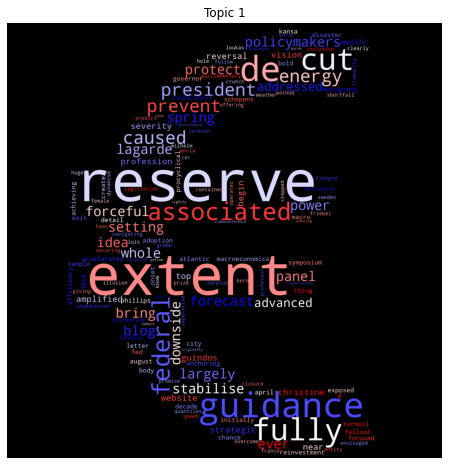

In [53]:
values = ','.join(str(v) for v in topics['Topic1']) 
# A similar function, but using the mask
def generate_better_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='bwr',
                      mask=mask,
                      background_color='black',
                      stopwords=stop,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(8 ,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(values, 'Topic 1', mask=euro)

### Choose sentences of certain topic relating to Economic conditions

In [ ]:
doc_topic = lda_model.transform(cv_features)
list_topic = []
for i in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[i].argmax()
    list_topic.append(topic_most_pr)
df_sent['topic'] = list_topic
df_sent.head(2)

In [56]:
sent6 = df_sent.loc[df_sent['topic']==6]
sent8= df_sent.loc[df_sent['topic']==8]
sent10 = df_sent.loc[df_sent['topic']==10]
sent12 = df_sent.loc[df_sent['topic']==12]
sent13 = df_sent.loc[df_sent['topic']==13]

In [64]:
sent_all = (sent6.append(sent8).append(sent10).append(sent12).append(sent13)).reset_index(drop = True)

In [69]:
sent_all.head(4) #each row is a sentence

,yymm,sent,topic
0,2020-12-16,"Public trust in the European Union (EU) and European institutions like the European Central Bank (ECB) has suffered considerable strain in recent years due to the global financial crisis, the European sovereign debt crisis and the UK’s withdrawal from the EU",6
1,2020-12-16,"In these stormy conditions, the “ship Europe” has, however, not run aground",6
2,2020-12-16,A “Havarie Europa” is therefore not within sight,6
3,2020-12-16,Why is public trust so critically important for central banks? Money is a credence good,6


In [78]:
df_ts = sent_all[ sent_all['sent'].astype(str) == sent_all['sent']] #only keep the content whose type data string
#merge sentences of the same date
df_ts['speeches'] = df_ts.groupby(['yymm'])['sent'].transform(lambda x: ','.join(x)) 
df_ts = df_ts[['yymm','speeches']].drop_duplicates()
df_ts.head(5)

yymm  \
0   2020-12-16   
49  2020-12-14   
65  2020-11-27   
82  2020-11-26   
106 2020-11-24   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Sentimental analysis - convert text to numerical value

In [66]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 7.6 MB/s eta 0:00:01


In [67]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Jyanqa/nltk_data...


True

In [79]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [87]:
analyzer = SentimentIntensityAnalyzer()
df_ts['neg'] = df_ts['speeches'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df_ts['neu'] = df_ts['speeches'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df_ts['pos'] = df_ts['speeches'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df_ts['compound'] = df_ts['speeches'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
data_ts = df_ts[['yymm','neg','neu','pos','compound']].reset_index()
data_ts.head(3)
data_ts.shape

(45, 6)

### Plot speeches time series

In [83]:
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

## Data yield

In [88]:
y3m = pd.read_csv('/Users/Jyanqa/Desktop/z_macro_Final_project/daily_data/y3m.csv', sep = ';')
y1y = pd.read_csv('/Users/Jyanqa/Desktop/z_macro_Final_project/daily_data/y1y.csv', sep = ';')
y2y = pd.read_csv('/Users/Jyanqa/Desktop/z_macro_Final_project/daily_data/y2y.csv', sep = ';')
y5y = pd.read_csv('/Users/Jyanqa/Desktop/z_macro_Final_project/daily_data/y5y.csv', sep = ';')
y10y = pd.read_csv('/Users/Jyanqa/Desktop/z_macro_Final_project/daily_data/y10y.csv', sep = ';')

In [95]:
#convert all date to datetime datatype
y3m['date'] = pd.to_datetime(y3m['date'])
y1y['date'] = pd.to_datetime(y1y['date'])
y2y['date'] = pd.to_datetime(y2y['date'])
y5y['date'] = pd.to_datetime(y5y['date'])
y10y['date'] = pd.to_datetime(y10y['date'])

In [96]:
print(y3m.shape)
print(y1y.shape)
print(y2y.shape)
print(y5y.shape)
print(y10y.shape)
#conlusion: we can guess that 5 data files have the same columns['date']

(865, 2)
(865, 2)
(865, 2)
(865, 2)
(865, 2)


In [114]:
from functools import reduce
#merger multi-dataframes
data_frames = [y3m, y1y, y2y, y5y, y10y]
# if you want to fill the values that don't exist in the lines of merged dataframe simply fill with required strings as
yieldday = reduce(lambda  a,b: pd.merge(a,b,on=['date'],
                                            how='outer'), data_frames).fillna('navalue')
yieldday

,date,3m,1y,2y,5y,10y
0,2018-01-02,-0.745998,-0.712228,-0.618449,-0.158394,0.537615
1,2018-01-03,-0.689726,-0.696930,-0.625850,-0.172192,0.521837
2,2018-01-04,-0.664711,-0.678375,-0.609208,-0.154146,0.532726
3,2018-01-05,-0.659469,-0.675266,-0.610466,-0.164337,0.523487
4,2018-01-08,-0.646781,-0.675209,-0.620244,-0.182959,0.506896
...,...,...,...,...,...,...
860,2021-05-25,-0.625553,-0.676107,-0.691282,-0.538744,-0.136654
861,2021-05-26,-0.625723,-0.680842,-0.702084,-0.565402,-0.178402
862,2021-05-27,-0.632183,-0.680295,-0.693915,-0.542849,-0.147109
863,2021-05-28,-0.626399,-0.679911,-0.698541,-0.553035,-0.154210


In [119]:
yieldday.to_csv('yieldday.csv', sep='\t', encoding='utf-8')